# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados

## <span style="color:darkred">Módulo I - Dados Estruturados e Não Estruturados</span>


### <span style="color:darkred">Problemas típicos em bases de dados: Outliers e informações errôneas</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

--- 

__Conteúdo:__
1. *Dados Não-estruturados* e *Estruturados*
2. Problemas típicos em bases de dados: informações faltantes
3. Pontos "fora da curva" (*outliers*)

__Referências:__
- Salvador García, Julián Luengo, Francisco Herrera. Data Processing in Data Mining, 2015.
- Hadley Wickham, Tidy Data. Journal of Statistical Software, v.59, n.10, 2014.
- Katti Faceli; Ana Carolina Lorena; João Gama; André C.P.L.F. Carvalho. Inteligência Artificial: uma abordagem de aprendizado de máquina, 2011.

__Referência complementar:__
- CHANDOLA, Varun; BANERJEE, Arindam; KUMAR, Vipin. Outlier detection: a survey. ACM Computing Surveys, v. 14, p. 15, 2007.

***

Vamos estudar os problemas: **Outliers e informacoes errôneas** utilizando um conjunto de dados de natalidade em uma maternidade, e que contém os seguintes atributos relativos aos nascidos:
* sexo, 
* peso do nascimento (em gramas), 
* idade gestacional (em semanas),
* mês do nascimento,
* ano do nascimento.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("./dados/TACTD_01-BCE_Outliers_Err_Desbal.csv")

print("Número de observacoes na base de dados: ", data.shape[0])
data.head()

Número de observacoes na base de dados:  72


,Sex,Weight,Gestational age,Month,Year
0,F,3490,38,11,2016
1,M,3650,39,11,2016
2,M,2740,34,11,2016
3,F,3380,39,12,2016
4,F,3820,38,12,2016


In [2]:
# vamos explorar a estatística descritiva dos dados!
data.describe()

,Weight,Gestational age,Month,Year
count,72.000000,72.000000,72.000000,72.000000
mean,3347.569444,37.666667,4.347222,2294.611111
std,625.807643,2.264235,3.600312,2357.042552
min,320.000000,32.000000,1.000000,2016.000000
25%,3100.000000,36.000000,2.000000,2017.000000
50%,3460.000000,38.000000,3.000000,2017.000000
75%,3682.500000,39.000000,5.000000,2017.000000
max,4810.000000,43.000000,12.000000,22017.000000


## B+C. *Outliers* e dados errôneos


#### Tipos de *outliers*

Também chamados de pontos "fora-da-curva" ou aberrantes. Os pontos não-outliers são às vezes chamados de inliers pois recaem "dentro" do esperado.

1. Globais ou anomalias de ponto

2. Contextuais ou condicionais

3. Coletivos

---


1. **Globais ou anomalias de ponto**: são ocorrências de valores *individuais* muito diferentes da maior parte dos dados disponíveis.

    Uma forma simples de identificar é gerar gráficos de caixa (ou *boxplots*) dos atributos/colunas da base de dados. Esse gráfico dá uma distribuição global dos dados e permite identificar aqueles cujo valor recaem fora da caixa que representa 50% dos dados, ou mesmo dos dados como um todo. 
    
    Idealmente, grafamos cada variável individualmente, pois elas tem intervalos de valores distintos! 
    * por exemplo, enquanto o peso está definido ao redor de milhares de gramas, a idade gestacional é em dezenas de semanas

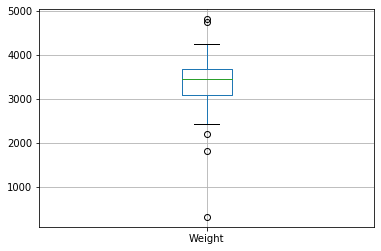

In [8]:
data.boxplot(column=['Weight'])

Notamos que a maior parte do peso está ao redor de 2500 e 4500, mas temos pontos bem distantes. Vamos tentar encontrá-los:

In [4]:
data[(data['Weight'] <= 2400) | (data['Weight'] >= 4300)]

,Sex,Weight,Gestational age,Month,Year
6,M,320,38,12,2016
19,F,2200,33,1,2017
38,M,4750,43,2,2017
41,F,4810,37,3,2017
45,F,1825,32,3,2017


Nessa primeira verificação, nota-se que a linha 6 possui um valor muito baixo (320 gramas) o qual é certamente um **outlier global** mas provavelmente é também um **dado errôneo**!

O motivo pode ser um erro de digitação ou inputação nesse caso. Se não quisermos prejudicar a análise, é preciso confirmar esse dado: se estiver disponível em outro base de dados ou meio físico, ou então descartá-lo.

In [19]:
# vamos definir como valor Not-a-number
data.loc[6,'Weight'] = np.NaN

Quanto as demais linhas, notamos valores altos (próximos a 4800) e baixos (1950). Nesses casos, parecem ser valores inputados corretamente e verdadeiros. 

Porém por desviar grandemente da maior parte dos dados são considerados também **outliers globais**.

No entanto, não iremos removê-lo a princípio pois não se tratam de dados errôneos.

Mostrando novamente o boxplot temos a distribuição dos dados sem o valor errôneo, e os 4 outliers globais indicados por círculos.

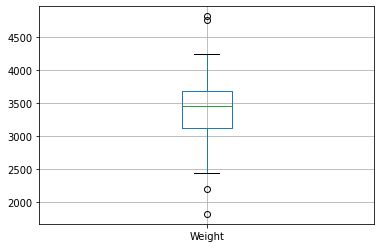

In [6]:
data.boxplot(column=['Weight'])

Dados errôneos podem aparecer não apenas na forma de outliers, mas também fora do padrão determinado. Por exemplo, vamos explorar a coluna relativa ao sexo do bebê, utilizando histograma e valores únicos.

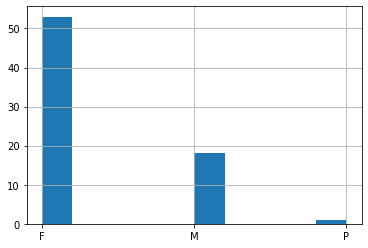

In [7]:
data['Sex'].hist()

In [8]:
data['Sex'].unique()

array(['F', 'M', 'P'], dtype=object)

Notamos um valor **P** que não pertence ao que é esperado. Esse dado foi corrompido de alguma forma e representa um dado **errôneo**. Devemos desconsiderá-lo, tornando-o um dado faltante.

In [9]:
data[data['Sex'] == 'P']


,Sex,Weight,Gestational age,Month,Year
16,P,3600.0,36,1,2017


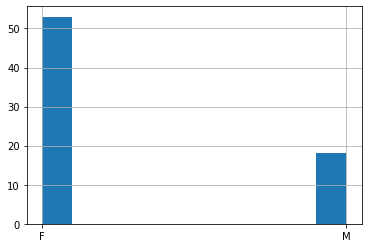

In [20]:
data.loc[16,'Sex'] = np.NaN
data['Sex'].hist()

---

2. **Contextuais**: são valores que, observados isoladamente podem não ser anômalos, mas que ao observar o contexto, sim!

    * Em dados **independentes e identicamente distribuídos**, na qual um exemplo (nascimento de um bebê) não afeta os próximos exemplos observados, como é o caso desse exemplo, temos que identificar o componente contextual.
    
    * Em dados **sequenciais** (como séries temporais, texto), em que uma observação influencia a próxima, o contexto é quase sempre o aspecto temporal/sequencial.
    
No nosso exemplo, podemos observar se há uma anomalia de peso com relação à idade gestacional!

Vamos considerar por exemplo que:
* bebês nascidos entre 38 e 42 semanas possuem tamanho normal se estiverem aproximadamente entre 2500 e 4000 gramas.
    
    Assim, podemos buscar por **outliers contextuais**, em que o peso saia fora desse intervalo dentro do período gestacional indicado.
    
    Podemos usar busca por fatiamento da base, e também *boxplots*

In [21]:
d_term = data[(data['Gestational age'] >= 38) & (data['Gestational age'] <= 42)]

# buscando por anomalias contextuais
d_term[ (d_term['Weight'] < 2500) | (d_term['Weight'] > 4000) ]

,Sex,Weight,Gestational age,Month,Year
62,F,4240.0,41,5,2017


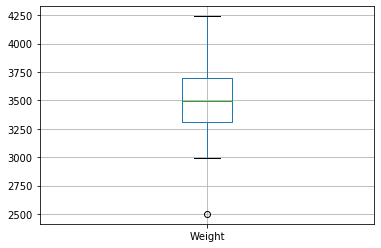

In [22]:
d_term.boxplot(column=['Weight'])

É interessante notar que o *boxplot* mostrou um outlier em 2500 gramas, enquanto nossa busca específica retornou apenas 4240 gramas em 41 semanas!

Vamos inspecionar esse caso:

In [23]:
d_term[ (d_term['Weight'] <= 2500)]

,Sex,Weight,Gestational age,Month,Year
25,M,2500.0,40,1,2017


Aqui, temos um caso limítrofe e precisamos da ajuda de especialistas para decidir o que significa esse *outlier*

--- 

3. **Coletivos**: um conjunto de observacões cujos valores, quando analisados em grupo, indicam um evento não usual.

    Em geral:
    * não são *outliers globais* pois seus valores recaem dentro da maior parte dos dados globalmente
    
    * não são *outliers contextuais* pois individualmente podem ser considerados normais quando observados num determinado contexto

No nosso exemplo, vamos analisar os dados relativos ao nascimento de bebês do sexo masculino e feminino, mês a mês.

In [24]:
data.groupby('Month')['Sex'].describe()

,count,unique,top,freq
Month,,,,
1,14,2,F,9
2,12,2,F,7
3,11,2,F,9
4,10,2,F,8
5,12,1,F,12
11,3,2,M,2
12,9,2,F,7


Observando a estatística descritiva acima, veja que no mês 5 há 12 ocorrências, mas apenas um único valor, **F**

Vamos visualizar:


In [27]:
data['Year'].value_counts()

2017     59
2016     12
22017     1
Name: Year, dtype: int64

In [15]:
data[data['Month'] == 5]

,Sex,Weight,Gestational age,Month,Year
60,F,2450.0,34,5,2017
61,F,3380.0,37,5,2017
62,F,4240.0,41,5,2017
63,F,3220.0,42,5,2017
64,F,3100.0,37,5,2017
65,F,3280.0,40,5,2017
66,F,4000.0,38,5,2017
67,F,4100.0,37,5,2017
68,F,3900.0,40,5,2017
69,F,3450.0,37,5,2017


De fato, observar apenas nascimento de bebês do sexo feminino em um determinado mês é um **outlier coletivo**.

Note que os valores de sexo e mês individualmente não indicam **outlier global**, e que, quando analisamos observacoes uma a uma, é normal que um bebê do sexo feminino nasca no mês 5, então também a análise individual não mostra **outlier contextual**.

Assim, apenas pela análise conjunta identificamos um comportamento de **outlier**.

## Resumo

Reconhecer outliers pode ser muito útil para entender os dados, e isso pode levar a diferentes aplicacoes:

* detectar dados errôneos
* detectar anomalias que possam ser reportadas

No entanto, é preciso ter conhecimento do domínio para ir além dos outliers globais, capturando também os contextuais e coletivos.
